In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import copy

from collections import Counter, defaultdict
from deap import base, creator, tools
from tqdm import tqdm

In [2]:
threshold = 0.3 #threshold di discriminazione
egoradius = 2 #Per link da aggiungere - raggio dell'egonetwork
delete = 0.5 #Per link da eliminare - top % con betweeness bassa rimovibili
attr_name = 'gender'

In [3]:
# add, remove, hybrid
mode = 'add'

In [4]:
fitness = 'marg'
#marg = marginalization score => somma abs(marg) dei singoli nodi / n.nodi => [0, 1]
#nodes = marginalized nodes

In [5]:
glob = True

#True = guardiamo solo link fra discriminati - discriminati "compatibili"
#False = guardiamo link fra discriminati - chiunque
#in entrambi casi sempre dentro l'egoradius
#e.g.: egoradius 2 => vicini-dei-vicini; 3 => vicini-dei-vicini + vicini-dei-vicini-dei-vicini


In [6]:
remove_missing = True
#True = rimuove
#False = rimpiazza con GA

# AMARE MI VA- Attribute-aware MARginalization Estimator with MIssing VAlues

In [7]:
g = nx.Graph()
g.name = 'copenhagen'
with open('bt_symmetric.csv') as f:
    for l in f.readlines()[1:]:
        tid, a, b, rssi = l.rstrip().split(',')
        g.add_edge(int(a),int(b), tid=tid)
print('loaded net')

attrs = {n: None for n in g.nodes()} # also fix missing data
with open('genders.csv') as f:
    for l in f.readlines()[1:]:
        node, gender = l.rstrip().split(',')
        attrs[int(node)] = gender
    nx.set_node_attributes(g, attrs, name=attr_name) #probabilmente inutile
print('loaded attributes')

missing = []
for n in attrs:
    if attrs[n] is None:
        missing.append(n)

#g.remove_nodes_from(missing)
#print('unlabeled removed')

loaded net
loaded attributes


In [8]:
print(nx.info(g))

Name: copenhagen
Type: Graph
Number of nodes: 708
Number of edges: 80886
Average degree: 228.4915


In [9]:
attrs = nx.get_node_attributes(g, attr_name)

In [10]:
def random_individual(binary_list):
    individual = []
    for e in binary_list:
        individual.append(random.randint(0,1)) 
        #with MV => 0: Attribute1; 1: Attribute2
        #with links => 0: do nothing; 1: add/remove
    return individual 

In [11]:
def evaluate_missing(individual, g, return_net):
    individual = individual[0] #<- because DEAP
    for node, attr in zip(missing, individual):
        attrs[node] = str(attr)
    
    sizes = dict(Counter(list(attrs.values())))
    sizes['0'] = (sizes['0'] - 1) / (len(g) - 1)
    sizes['1'] = (sizes['1'] - 1) / (len(g) - 1)
    weights = dict(Counter(list(attrs.values())))
    weights['0'] = 1 - sizes['0']
    weights['1'] = 1 - sizes['1']
    
    marg_dict = dict()

    for node in g.nodes():
        attr = attrs[node]

        # COMPUTE MARGINALIZATION
        marg = 0
        egonet = list(g.neighbors(node))
        egonet_attrs = [attrs[n] for n in egonet]
        size = len(egonet_attrs)

        if size > 2:
            try:
                count = dict(Counter(egonet_attrs))[attr]
                marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            except:
                marg = 1
        else:
            marg = 0

        marg_dict[node] = marg

    disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]

    ov_marg = np.mean([abs(v) for v in marg_dict.values()]) #network marginalization score
    
    if return_net:
        return attrs, weights, marg_dict, disc_nodes, ov_marg#, base_marg
    
    if fitness == 'marg':
        return ov_marg, len(disc_nodes)
    elif fitness == 'nodes':
        return len(disc_nodes), ov_marg



100%|██████████| 673/673 [00:00<00:00, 41920.62it/s]

35 nodes with missing labels removed

Marginalized nodes: 38 5.65
Network Marginalization Score: 0.10877333738775614


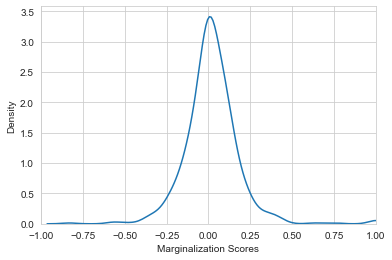

In [12]:
if remove_missing:
    g.remove_nodes_from(missing)
    print(len(missing), 'nodes with missing labels removed')
    
    attrs = nx.get_node_attributes(g, attr_name)
    
    sizes = dict(Counter(list(attrs.values())))
    sizes['0'] = (sizes['0'] - 1) / (len(g) - 1)
    sizes['1'] = (sizes['1'] - 1) / (len(g) - 1)
    weights = dict(Counter(list(attrs.values())))
    weights['0'] = 1 - sizes['0']
    weights['1'] = 1 - sizes['1']
    
    marg_dict = dict()

    for node in tqdm(g.nodes()):
        attr = attrs[node]

        # COMPUTE MARGINALIZATION
        marg = 0
        egonet = list(g.neighbors(node)) #+ [node]
        egonet_attrs = [attrs[n] for n in egonet]
        size = len(egonet_attrs)

        if size > 2:
            try:
                count = dict(Counter(egonet_attrs))[attr]
                marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            except:
                marg = 1
        else:
            marg = 0

        marg_dict[node] = marg

    disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
    disc = len(disc_nodes)

    ov_marg = np.mean([abs(v) for v in marg_dict.values()]) #network marginalization score

else: #vogliamo rimpiazzare MV
    return_net = False #if True, eva function returns the fair network. INSIDE THE GA, IT MUST BE FALSE

    creator.create("Fitness", base.Fitness, weights=(-1.0,-1.0)) # <- -1 perché vogliamo minimizzare la fitness
    creator.create("Individual", list, fitness=creator.Fitness) #<- l'individuo è definito come lista

    toolbox = base.Toolbox() #creiamo il toolbox

    toolbox.register("random_individual", random_individual, missing) 
    #"nome_della_funzione per deap", nome_della_funzione vera e propria di python, parametri che passi alla funzione

    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                     toolbox.random_individual, n=1) 
    # n = numero di individui nella popolazione. Lasciamo 1

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate_missing", evaluate_missing, g=g, return_net=return_net) #funzione di valutazione. Vedi quanto detto sopra
    toolbox.register("mate", tools.cxTwoPoint) #funzione di crossover
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #funzione di mutazione custom
    toolbox.register("select", tools.selTournament, tournsize=3)
    #tools.selNSGA2) #funzione di selezione

    print('Fitness:', fitness)
    NUM_GENERATIONS = 30 #numero di generazioni
    POPULATION_SIZE = 150 #popolazione per gen

    CXPB, MUTPB = 0.5, 0.25 #crossover e mutation probability

    n_HOF = 10 #top soluzioni da ritornare (la "Hall of Fame" di DEAP è il set di tutte le top n soluzioni)

    pop = toolbox.population(n=POPULATION_SIZE)

    hof = tools.HallOfFame(n_HOF)

    stats = tools.Statistics(lambda ind: ind.fitness.values[0])   
    stats.register('min', np.min, axis = 0)
    stats.register('avg', np.mean, axis = 0)

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields

    invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate_missing, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit

    hof.update(pop)
    hof_size = len(hof.items)

    record = stats.compile(pop)
    logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
    print(logbook.stream)

    for gen in range(1, NUM_GENERATIONS + 1):

                # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))


        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1[0], child2[0])
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant[0])
                del mutant.fitness.values


        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate_missing, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        hof.update(offspring)

        # Replace the current population by the offspring
        pop[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(pop) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)


    hof.update(pop) # la HoF è aggiornata con la nuova popolazione (o meglio, i suoi individui migliori w.r.t. fitness)

    plt.figure(1)

    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    #plt.plot(maxFitnessValues, color='red')
    plt.plot(minFitnessValues, color='blue')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    if fitness == 'nodes':
        plt.ylabel('Marginalized Nodes')
        plt.title('Avg and Min Marginalized Nodes')
    elif fitness == 'marg':
        plt.ylabel('Marginalization Score')
        plt.title('Avg and Min Marginalization Score')    
    # show both plots:
    plt.show()


    attrs, weights, marg_dict, disc_nodes, ov_marg = evaluate_missing(hof.items[0], g, True)
    nx.set_node_attributes(g, attrs, name=attr_name)
    print('Replaced', len(missing), 'missing labels')


print("")
print("Marginalized nodes:", len(disc_nodes), round(len(disc_nodes) * 100 / len(g.nodes()), 2))
print("Network Marginalization Score:", ov_marg)
sns.set_style("whitegrid")
fig, ax = plt.subplots()
sns.kdeplot(list(marg_dict.values()), ax=ax)
plt.xlabel('Marginalization Scores')
ax.set_xlim(-1, 1)
plt.show()

100%|██████████| 673/673 [00:00<00:00, 45571.12it/s]



Marginalized nodes: 38 5.65
Network Marginalization Score: 0.10877333738775614


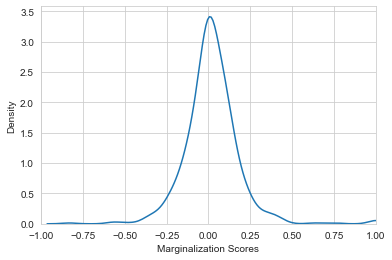

In [13]:
sizes = dict(Counter(list(attrs.values())))
sizes['0'] = (sizes['0'] - 1) / (len(g) - 1)
sizes['1'] = (sizes['1'] - 1) / (len(g) - 1)
weights = dict(Counter(list(attrs.values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

marg_dict = dict()

for node in tqdm(g.nodes()):
    attr = attrs[node]

    marg = 0
    egonet = list(g.neighbors(node)) #+ [node]
    egonet_attrs = [attrs[n] for n in egonet]
    size = len(egonet_attrs)

    if size > 2:
        try:
            count = dict(Counter(egonet_attrs))[attr]
            marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
        except:
            marg = 1
    else:
        marg = 0

    marg_dict[node] = marg

disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
disc = len(disc_nodes)

ov_marg = np.mean([abs(v) for v in marg_dict.values()]) #network marginalization score

print("")
print("Marginalized nodes:", len(disc_nodes), round(len(disc_nodes) * 100 / len(g.nodes()), 2))
print("Network Marginalization Score:", ov_marg)

fig, ax = plt.subplots()
sns.kdeplot(list(marg_dict.values()), ax=ax)
plt.xlabel('Marginalization Scores')
ax.set_xlim(-1, 1)
plt.show()

In [14]:
if mode == 'remove': #se solo rimozione, non vengono aggiunti
    possible_links = [] 
else:
    plausible = nx.Graph() # stores plausible links

    for node in tqdm(disc_nodes):
        egonet = list(g.neighbors(node)) #+ [node]
        egonet2 = nx.ego_graph(g, node, center=False, radius=egoradius)
        egonet2.remove_nodes_from(egonet)
        if glob:
            for n in egonet2.nodes():
                if node != n and n in disc_nodes:
                    if marg_dict[node] > 0:
                        if attrs[n] != attrs[node]:
                            plausible.add_edge(node, n)
                    elif marg_dict[node] < 0:
                        if attrs[n] == attrs[node]:
                            plausible.add_edge(node, n)         
                    else:
                        print("ERROR #01")
        else:
            for n in egonet2.nodes():
                if node != n:
                    plausible.add_edge(node, n)
                    
                
    possible_links = list(plausible.edges())

100%|██████████| 38/38 [00:08<00:00,  4.22it/s]


In [15]:
if mode == 'add': #se solo aggiunta, non vengono rimossi
    weak_links = []
else:
    #Betweenness centrality su archi
    betweenness = nx.edge_betweenness_centrality(g) #dizionario di archi con score di BW centrality

    marg_betweenness = dict()
    
    if glob:
        for k, v in tqdm(betweenness.items()):
            if k[0] in disc_nodes and k[1] in disc_nodes:
                if marg_dict[k[0]] > 0:
                    if attrs[k[0]] == attrs[k[1]]:
                        marg_betweenness[k] = v
                elif marg_dict[k[0]] < 0:
                    if attrs[k[0]] != attrs[k[1]]:
                        marg_betweenness[k] = v
                else:
                    print ("ERROR #02")        
    else:
        for k, v in tqdm(betweenness.items()):
            if k[0] in disc_nodes or k[1] in disc_nodes: 
                    marg_betweenness[k] = v
    
    marg_betweenness = dict(sorted(marg_betweenness.items(), key=lambda item: item[1]))
    weak_links = list(marg_betweenness.keys())[:round(len(marg_betweenness) * delete)]


In [16]:
links = possible_links + weak_links #tutti i links con cui il GA opera
print("Links:", len(links))

Links: 427


# MARK - MArginalization Reducer using linK

In [17]:
#def random_individual(links):
 #   individual = []
  #  for e in links:
   #     individual.append(random.randint(0,1)) #1 = aggiunto/rimosso; 0 = do nothing
    #return individual 

In [18]:
def evaluate(individual, g, return_net):
    individual = individual[0] #<- because DEAP
        
    eva_g = copy.deepcopy(g) #copy of OG network, modified for testing the solution
    
    indexes = [i for i, j in enumerate(individual) if j == 1]
    new_links = [links[i] for i in indexes]
    
    node_list = list(set(list(sum(new_links,())))) #nodes affected by tested solution

    nodes = 0 #amount of marginalized nodes in network after applying the solution
    fair_marg = [abs(v) for k, v in marg_dict.items() if k not in node_list] #marg score of network after applying the solution
    
    for l in new_links:
        if l in possible_links:
            eva_g.add_edge(l[0], l[1])
        elif l in weak_links:
            eva_g.remove_edge(l[0], l[1])
            
    for node in node_list:
        attr = attrs[node] ###aggiunto

        egonet = list(eva_g.neighbors(node)) #+ [node]
        egonet_attrs = [attrs[n] for n in egonet]
        size = len(egonet)

        if size > 2:
            try:
                count = dict(Counter(egonet_attrs))[attr]
                marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            except:
                marg = 1
        else:
            marg = 0

        fair_marg.append(abs(marg))
        if abs(marg) > threshold:
            nodes += 1
                
    budget = sum(individual) #i.e., links added/removed. Less is better
    
    if return_net:
        return nodes, np.mean(fair_marg), budget, eva_g
    
    if fitness == 'nodes':      
        return nodes, budget
    elif fitness == 'marg':
        return np.mean(fair_marg), budget
    else:
        print ("ERROR #03")
        

In [19]:
return_net = False #if True, eva function returns the fair network. INSIDE THE GA, IT MUST BE FALSE

creator.create("Fitness", base.Fitness, weights=(-1.0,-1.0)) # <- -1 perché vogliamo minimizzare la fitness
creator.create("Individual", list, fitness=creator.Fitness) #<- l'individuo è definito come lista

toolbox = base.Toolbox() #creiamo il toolbox

toolbox.register("random_individual", random_individual, links) 
#"nome_della_funzione per deap", nome_della_funzione vera e propria di python, parametri che passi alla funzione

toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.random_individual, n=1) 
# n = numero di individui nella popolazione. Lasciamo 1

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, g=g, return_net=return_net) #funzione di valutazione. Vedi quanto detto sopra
toolbox.register("mate", tools.cxTwoPoint) #funzione di crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #funzione di mutazione custom
toolbox.register("select", tools.selTournament, tournsize=3)
#tools.selNSGA2) #funzione di selezione

Marg nodes: 38 · Marg Score: 0.10877333738775614 · Available links: 427
Fitness: marg
gen	nevals	min      	avg      
0  	150   	0.0972417	0.0988545
1  	95    	0.0970279	0.0982713
2  	88    	0.0969098	0.097973 
3  	101   	0.0966532	0.0977541
4  	90    	0.0965039	0.097464 
5  	87    	0.0961314	0.0973545
6  	80    	0.0961314	0.0971232
7  	90    	0.0957356	0.0968569
8  	105   	0.095492 	0.0966393
9  	79    	0.095492 	0.0963788
10 	87    	0.0954988	0.0961884
11 	83    	0.0954212	0.0959417
12 	102   	0.0951459	0.0958572
13 	83    	0.0952037	0.0957135
14 	97    	0.0950647	0.0956593
15 	97    	0.0950508	0.0955311
16 	98    	0.0948506	0.0954614
17 	103   	0.0948436	0.0953575
18 	104   	0.0947485	0.0953593
19 	106   	0.0945588	0.0952505
20 	111   	0.0945536	0.095229 
21 	87    	0.0945536	0.0951057
22 	82    	0.0945536	0.0949734
23 	110   	0.0942857	0.095089 
24 	91    	0.0942548	0.0949345
25 	96    	0.0941059	0.094752 
26 	99    	0.0940755	0.0946773
27 	81    	0.0940809	0.0944532
28 	101   	0.09

<Figure size 432x288 with 0 Axes>

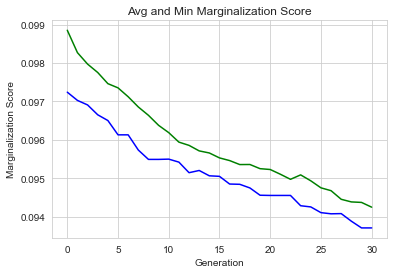

In [20]:
print('Marg nodes:', len(disc_nodes), '· Marg Score:', ov_marg, '· Available links:', len(links))
print('Fitness:', fitness)
NUM_GENERATIONS = 30 #numero di generazioni
POPULATION_SIZE = 150 #popolazione per gen

CXPB, MUTPB = 0.5, 0.25 #crossover e mutation probability

n_HOF = 10 #top soluzioni da ritornare (la "Hall of Fame" di DEAP è il set di tutte le top n soluzioni)

pop = toolbox.population(n=POPULATION_SIZE)

hof = tools.HallOfFame(n_HOF)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])   
stats.register('min', np.min, axis = 0)
stats.register('avg', np.mean, axis = 0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

hof.update(pop)
hof_size = len(hof.items)

record = stats.compile(pop)
logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
print(logbook.stream)

for gen in range(1, NUM_GENERATIONS + 1):

            # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))


    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant[0])
            del mutant.fitness.values


    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    pop[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)


hof.update(pop) # la HoF è aggiornata con la nuova popolazione (o meglio, i suoi individui migliori w.r.t. fitness)

plt.figure(1)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
#plt.plot(maxFitnessValues, color='red')
plt.plot(minFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
if fitness == 'nodes':
    plt.ylabel('Marginalized Nodes')
    plt.title('Avg and Min Marginalized Nodes')
elif fitness == 'marg':
    plt.ylabel('Marginalization Score')
    plt.title('Avg and Min Marginalization Score')    
# show both plots:
plt.show()


#return hof.items

In [21]:
best = hof.items[0][0]

In [22]:
fair_nodes, fair_score, fair_budget, fair_net = evaluate([best], g, True)

print ("Marg Nodes:", fair_nodes, '· Prev:', len(disc_nodes))
print ("Marg Score:", np.mean(fair_score), '· Prev:', ov_marg)
print ("Links:", fair_net.number_of_edges(), '· Prev:', g.number_of_edges())
if mode == 'add': 
    print ("Added links:", fair_budget)
elif mode == 'remove':
    print ("Removed links:", fair_budget)
elif mode == 'hybrid':
    print ("Modified links:", fair_budget)
    added = fair_net.number_of_edges() - g.number_of_edges()
    print ("-- of which added:", added)
    print ("-- of which removed:", fair_budget - added)

Marg Nodes: 7 · Prev: 38
Marg Score: 0.09370815890208072 · Prev: 0.10877333738775614
Links: 75364 · Prev: 75124
Added links: 240


100%|██████████| 673/673 [00:00<00:00, 43880.84it/s]


Marginalized nodes: 7 1.04
Network Marginalization Score: 0.09370815890208072


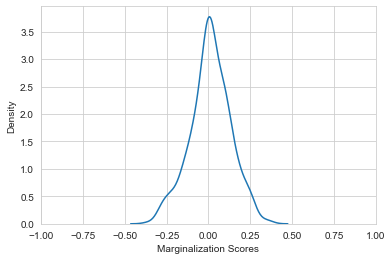

In [23]:
g = fair_net

attrs = nx.get_node_attributes(g, attr_name)
    
sizes = dict(Counter(list(attrs.values())))
sizes['0'] = (sizes['0'] - 1) / (len(g) - 1)
sizes['1'] = (sizes['1'] - 1) / (len(g) - 1)
weights = dict(Counter(list(attrs.values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

marg_dict = dict()

for node in tqdm(g.nodes()):
    attr = attrs[node]

    marg = 0
    egonet = list(g.neighbors(node)) #+ [node]
    egonet_attrs = [attrs[n] for n in egonet]
    size = len(egonet_attrs)

    if size > 2:
        try:
            count = dict(Counter(egonet_attrs))[attr]
            marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
        except:
            marg = 1
    else:
        marg = 0

    marg_dict[node] = marg

disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
disc = len(disc_nodes)

ov_marg = np.mean([abs(v) for v in marg_dict.values()]) #network marginalization score

print("")
print("Marginalized nodes:", len(disc_nodes), round(len(disc_nodes) * 100 / len(g.nodes()), 2))
print("Network Marginalization Score:", ov_marg)

fig, ax = plt.subplots()
sns.kdeplot(list(marg_dict.values()), ax=ax)
plt.xlabel('Marginalization Scores')
ax.set_xlim(-1, 1)
plt.show()